In [1]:
import sys
sys.path.append('../scripts')

from utils import *

# Game Collaboration Network

Which game developers and publishers are most interconnected through collaborative efforts, sharing resources, or co-producing games?

In [2]:
df_main = pd.read_csv('../data/steam.csv',
                      usecols=['name', 'developer', 'publisher'])

df = (
    df_main[['developer', 'publisher']]
    .dropna()
    .applymap(lambda x: x.split(';'))
    .explode('developer')
    .explode('publisher')
    .reset_index(drop=True)
)

# Convert strings to ASCII
df = df.applymap(unidecode)

In [3]:
devs = set(df.developer)
pubs = set(df.publisher)

# For color-coding in visualization
dev_pub = set.intersection(devs, pubs)
dev_only = set.difference(devs, pubs)
pub_only = set.difference(pubs, devs)

print(f'Number of Developers: {len(dev_only)}')
print(f'Number of Publishers: {len(pub_only)}')
print(f'Number of Self-Publishers: {len(dev_pub)}')

Number of Developers: 5843
Number of Publishers: 2258
Number of Self-Publishers: 12086


## Deciding $k$-core of network

In [4]:
edge_dict = {}

for idx, row in df.iterrows():
    pair = (row.developer, row.publisher)
    if (pair in edge_dict.keys()) or (pair[::-1] in edge_dict.keys()):
        if pair in edge_dict.keys():
            edge_dict[pair] += 1
        elif pair[::-1] in edge_dict.keys():
            edge_dict[pair[::-1]] += 1
    else:
        edge_dict[pair] = 1

df_weighted_edges = (
    pd.DataFrame(
        [(nodes[0], nodes[1], weight) for nodes, weight in edge_dict.items()],
        columns=['node1', 'node2', 'weight']
    )
    .sort_values('weight', ascending=False)
    .reset_index(drop=True)
)

# Convert all strings to ASCII
df_weighted_edges.head()

,node1,node2,weight
0,Choice of Games,Choice of Games,94
1,"KOEI TECMO GAMES CO., LTD.","KOEI TECMO GAMES CO., LTD.",70
2,Ripknot Systems,Ripknot Systems,62
3,"Nikita ""Ghost_RUS""",Ghost_RUS Games,51
4,Laush Dmitriy Sergeevich,Laush Studio,47


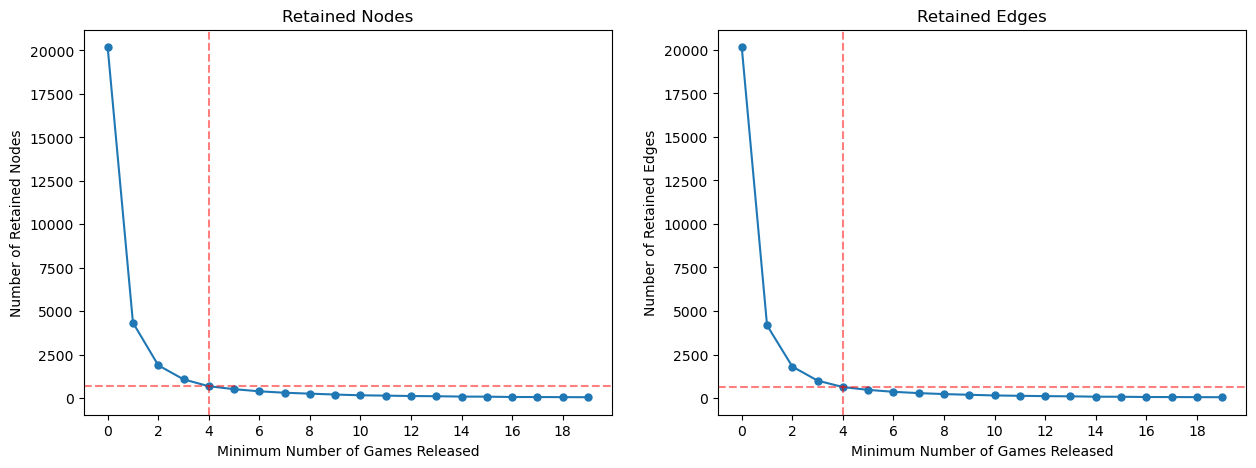

In [5]:
retained_nodes = []
retained_edges = []
for num_games in range(20):
    df_filtered = df_weighted_edges[df_weighted_edges.weight > num_games]
    
    retained_nodes.append(len(set.union(
        set(df_filtered.node1), set(df_filtered.node2)
    )))
    retained_edges.append(len(df_filtered))

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for ax, retained, entity in zip(axes.flat,
                      [retained_nodes, retained_edges],
                      ['Nodes', 'Edges']):
    ax.plot(retained, marker='o', markersize=5)
    ax.set_title(f'Retained {entity}')
    ax.set_xlabel('Minimum Number of Games Released')
    ax.set_ylabel(f'Number of Retained {entity}')
    ax.set_xticks(range(0, 20, 2))
    ax.axvline(x=4, c='r', ls='--', alpha=0.5)
    ax.axhline(y=retained[4], c='r', ls='--', alpha=0.5)
plt.savefig('../figures/minimum-weight-scree-plot.png', dpi=300)

## $4$-core Steam network

In [6]:
num_games = 4

# Filter out edges with weight less than num_games, and self-loops.
df_filtered = (
    df_weighted_edges[
        (df_weighted_edges.weight > num_games)
        & (df_weighted_edges.node1 != df_weighted_edges.node2)
    ]
)

In [7]:
G = nx.from_pandas_edgelist(df_filtered, 'node1', 'node2', edge_attr='weight',
                            create_using=nx.Graph())
get_graph_stats(G)

Total number of nodes: 311
Total number of edges: 211

Minimum degree: 1
Maximum degree: 11
Average degree: 0.68

Network density: 0.44%


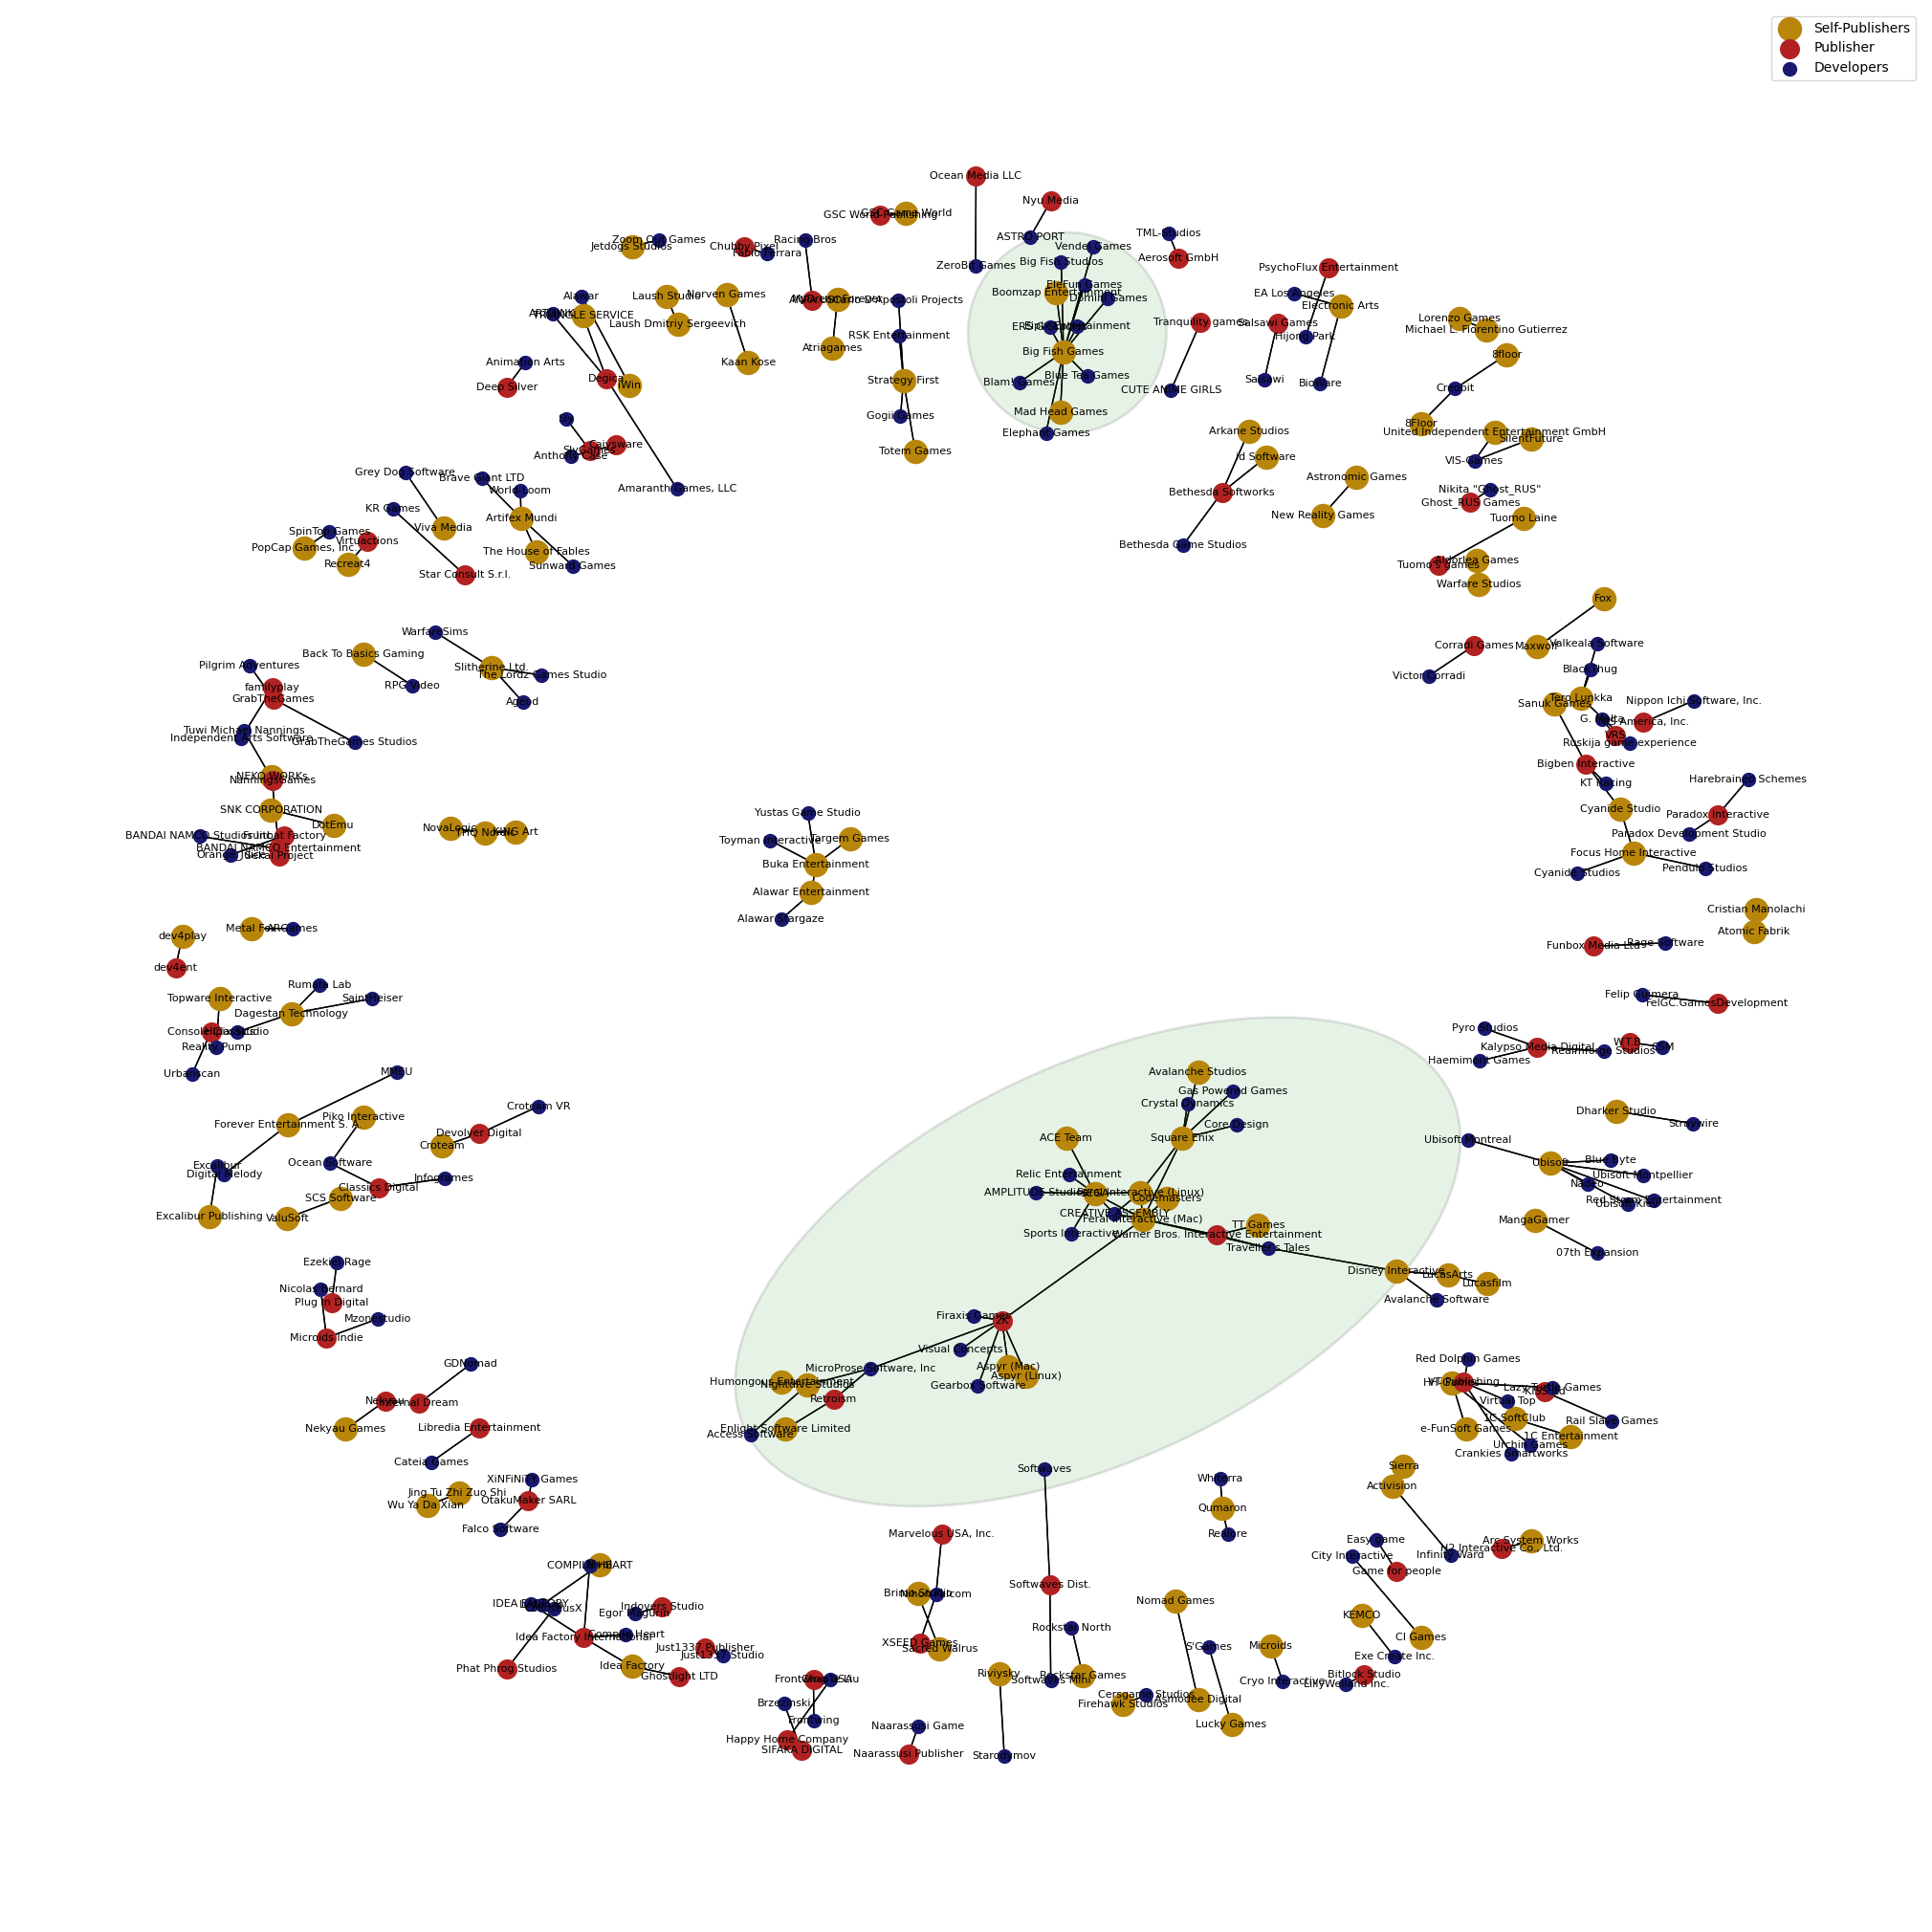

In [8]:
pos = nx.spring_layout(G, seed=0, k=0.21)

retained_devs = []
retained_pubs = []
retained_self_pubs = []
for node in G.nodes():
    if node in dev_only:
        retained_devs.append(node)
    elif node in pub_only:
        retained_pubs.append(node)
    elif node in dev_pub:
        retained_self_pubs.append(node)

# Draw the network with labels and colored nodes
plt.figure(figsize=(20, 20))

nx.draw(G, pos, with_labels=True, font_size=8, node_size=1)
nx.draw_networkx_nodes(
    G, pos, nodelist=retained_self_pubs, node_size=300,
    node_color='darkgoldenrod', label='Self-Publishers'
)
nx.draw_networkx_nodes(
    G, pos, nodelist=retained_pubs, node_size=200, node_color='firebrick',
    label='Publisher'
)
nx.draw_networkx_nodes(
    G, pos, nodelist=retained_devs, node_size=100, node_color='midnightblue',
    label='Developers'
)
nx.draw_networkx_edges(G, pos, edgelist=G.edges)


connected_components = sorted(nx.connected_components(G), key=len,
                              reverse=True)
top_components = connected_components[:2]
for component in top_components:
    node_list = list(component)
    node_positions = [pos[node] for node in node_list]
    center_x = sum([x for x, y in node_positions]) / len(node_positions)
    center_y = sum([y for x, y in node_positions]) / len(node_positions)
    radius = max(max(abs(center_x - x), abs(center_y - y)) for x, y in node_positions)
    if component == top_components[0]:
        circle = patches.Ellipse(
            (center_x, center_y), 2*radius, radius, angle=25,
            edgecolor='black', alpha=0.1, facecolor='g', lw=2
        )
    else:
        circle = patches.Circle(
            (center_x, center_y), radius, edgecolor='black', alpha=0.1,
            facecolor='g', lw=2
        )
    plt.gca().add_patch(circle)

# plt.title('Game Company Network')
plt.legend()
plt.axis('off')
plt.savefig('../figures/game-company-network.png', dpi=300)

In [9]:
components = np.array(list(nx.connected_components(G)))

# Count the number of nodes in each component
component_sizes = pd.Series(
    {i: len(component) for i, component in enumerate(components)}
).sort_values(ascending=False)

# Developers and Publishers in the top two clusters
top_dev_pub = set.union(*components[component_sizes.index[:2]])

df_top_dev_pub = pd.Series(list(top_dev_pub)).rename('developer_publisher')
df_top_dev_pub.to_csv('../data/developer_publisher.csv', index=False)

In [10]:
subgraph = G.subgraph(top_dev_pub)
get_graph_stats(subgraph)

Total number of nodes: 45
Total number of edges: 50

Minimum degree: 1
Maximum degree: 11
Average degree: 1.11

Network density: 5.05%


In [11]:
get_central_nodes_as_series(subgraph, nx.degree_centrality)

Big Fish Games                            0.250000
Feral Interactive (Mac)                   0.181818
2K                                        0.159091
SEGA                                      0.159091
Square Enix                               0.136364
Feral Interactive (Linux)                 0.113636
Warner Bros. Interactive Entertainment    0.068182
MicroProse Software, Inc                  0.068182
Nightdive Studios                         0.068182
Traveller's Tales                         0.068182
dtype: float64

In [12]:
get_central_nodes_as_series(subgraph, nx.betweenness_centrality)

Feral Interactive (Mac)     0.371564
2K                          0.285412
MicroProse Software, Inc    0.149049
SEGA                        0.124736
Square Enix                 0.124736
Traveller's Tales           0.118393
Disney Interactive          0.094080
Nightdive Studios           0.064482
Big Fish Games              0.058140
Retroism                    0.032770
dtype: float64

In [13]:
get_central_nodes_as_series(subgraph, nx.closeness_centrality)

Feral Interactive (Mac)                   0.342246
2K                                        0.302243
Feral Interactive (Linux)                 0.267503
SEGA                                      0.261491
Traveller's Tales                         0.261491
Square Enix                               0.258586
Warner Bros. Interactive Entertainment    0.252964
CREATIVE ASSEMBLY                         0.250244
Big Fish Games                            0.250000
Codemasters                               0.237477
dtype: float64

In [14]:
get_central_nodes_as_series(subgraph, nx.eigenvector_centrality)

Feral Interactive (Mac)                   0.520032
Feral Interactive (Linux)                 0.412935
SEGA                                      0.385385
CREATIVE ASSEMBLY                         0.314539
Square Enix                               0.288216
Codemasters                               0.222592
2K                                        0.201845
Traveller's Tales                         0.177637
Warner Bros. Interactive Entertainment    0.176500
Sports Interactive                        0.091947
dtype: float64

In [15]:
callables = [
    nx.degree_centrality,
    nx.betweenness_centrality,
    nx.closeness_centrality,
    nx.eigenvector_centrality
]

# Get developers and publishers that are Top 10 in all centrality measures.
central_dev_pub = set()
concat_list = {}
for centrality_fn in callables:
    series = get_central_nodes_as_series(subgraph, centrality_fn)
    concat_list.update({centrality_fn.__name__: series})
    if central_dev_pub == set():
        central_dev_pub = central_dev_pub.union(set(series.index))
    else:
        central_dev_pub = central_dev_pub.intersection(set(series.index))

df_central_nodes = pd.concat(concat_list, axis=1).loc[list(central_dev_pub)]
with pd.option_context('display.precision', 4):
    display(df_central_nodes)

,degree_centrality,betweenness_centrality,closeness_centrality,eigenvector_centrality
Feral Interactive (Mac),0.1818,0.3716,0.3422,0.5200
Square Enix,0.1364,0.1247,0.2586,0.2882
SEGA,0.1591,0.1247,0.2615,0.3854
Traveller's Tales,0.0682,0.1184,0.2615,0.1776
2K,0.1591,0.2854,0.3022,0.2018


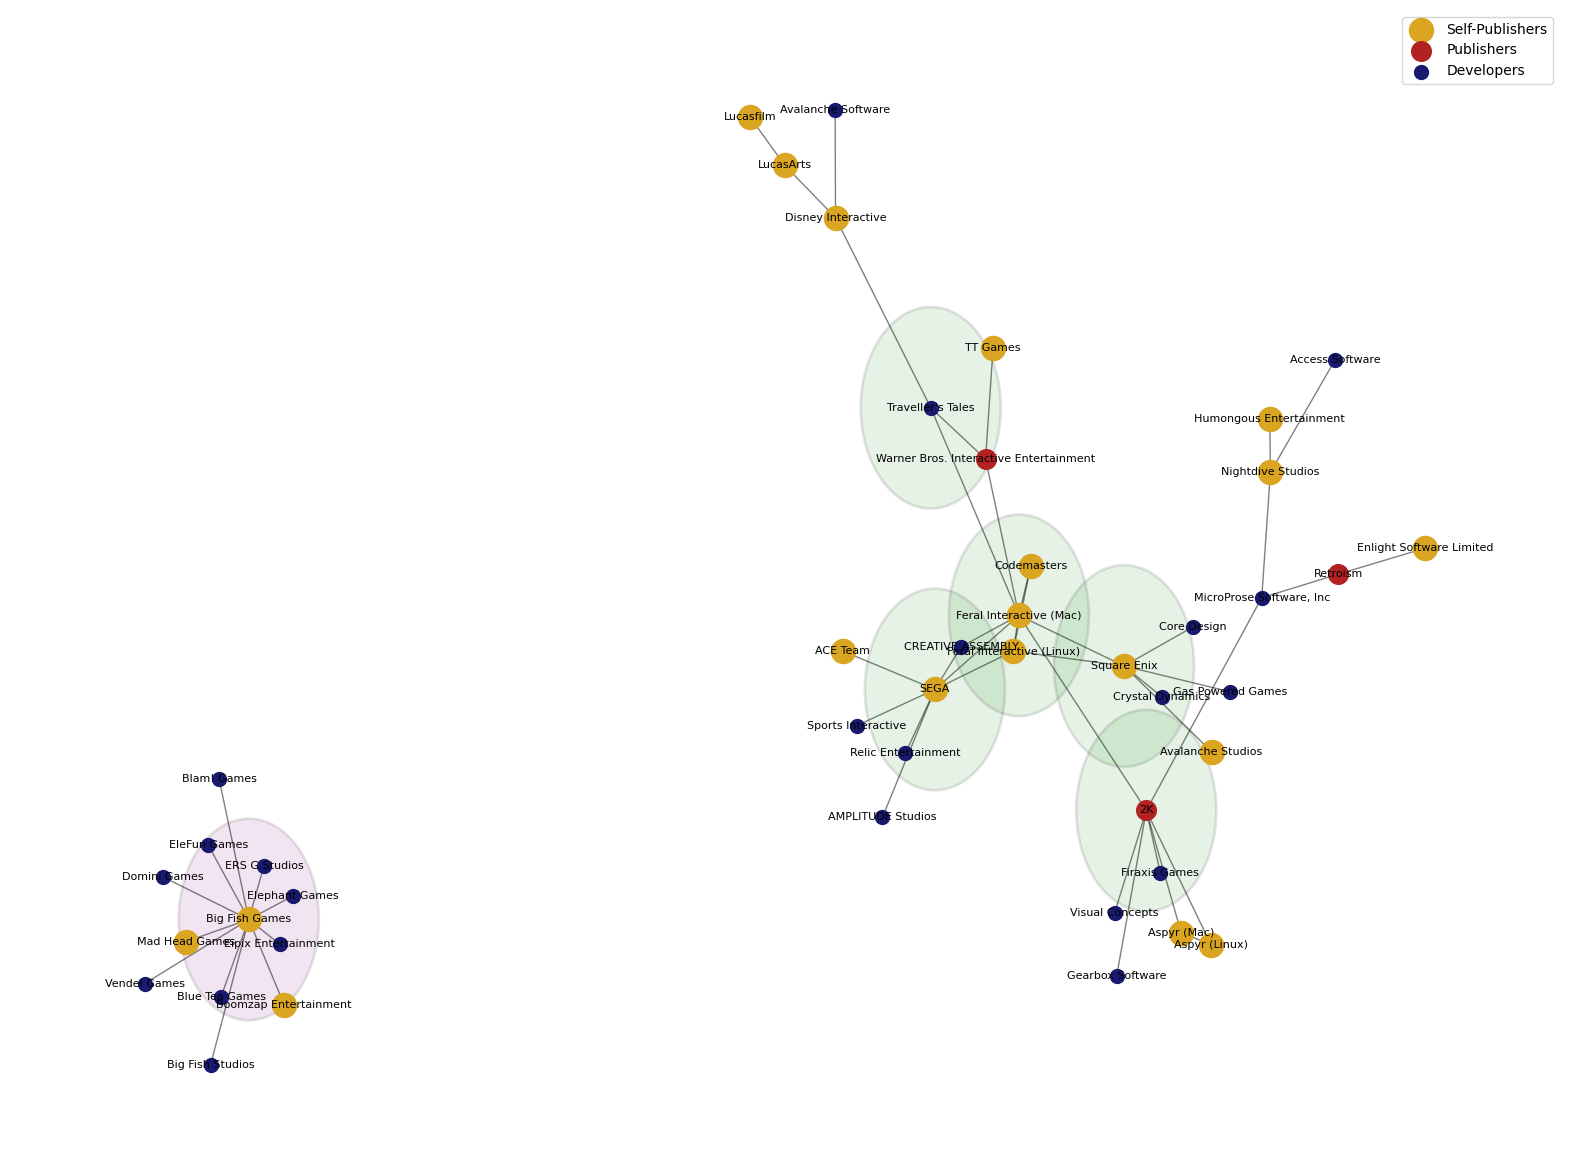

In [17]:
node_colors = []
for node in subgraph.nodes():
    if node in dev_only:
        node_colors.append('midnightblue')
    elif node in pub_only:
        node_colors.append('firebrick')
    elif node in dev_pub:
        node_colors.append('goldenrod')
    else:
        node_colors.append('gray')

pos = nx.spring_layout(subgraph, k=0.2, seed=0)
        
# Plot the subgraph
plt.figure(figsize=(20, 15))
nx.draw_networkx_nodes(
    subgraph, pos,
    nodelist=np.array(
        subgraph.nodes
    )[np.argwhere(np.array(node_colors) == 'goldenrod').flatten()],
    node_color='goldenrod',
    node_size=300,
    label='Self-Publishers'
)
nx.draw_networkx_nodes(
    subgraph, pos,
    nodelist=np.array(
        subgraph.nodes
    )[np.argwhere(np.array(node_colors) == 'firebrick').flatten()],
    node_color='firebrick',
    node_size=200,
    label='Publishers'
)
nx.draw_networkx_nodes(
    subgraph, pos,
    nodelist=np.array(
        subgraph.nodes
    )[np.argwhere(np.array(node_colors) == 'midnightblue').flatten()],
    node_color='midnightblue',
    node_size=100,
    label='Developers'
)
nx.draw_networkx_edges(subgraph, pos, alpha=0.5)

for node in df_central_nodes.index:
    circle = patches.Circle(
        pos[node], 0.1, edgecolor='black', alpha=0.1,
        facecolor='g', lw=2
    )
    plt.gca().add_patch(circle)
circle = patches.Circle(
    pos['Big Fish Games'], 0.1, edgecolor='black', alpha=0.1,
    facecolor='purple', lw=2
)
plt.gca().add_patch(circle)

# Draw node labels
nx.draw_networkx_labels(subgraph, pos, font_size=8, font_color='black')
# nx.draw(subgraph, with_labels=True, node_size=300, font_size=10)
# plt.title(f'Top 2 Clusters of Developers and Publishers')
plt.legend()
plt.axis('off')
plt.savefig('../figures/top2-dev-pub-clusters.png', dpi=300)